End-to-end (current focus: Readmission with XGBoost + Optuna). Structure prepared for mortality & prolonged LOS later.

In [19]:
# Environment & core imports
import os, sys, json, random, platform, importlib, datetime
from pathlib import Path
import numpy as np, pandas as pd
SEED = 42
random.seed(SEED); np.random.seed(SEED)
PROJECT_ROOT = (Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd())
DATA_DIR = PROJECT_ROOT / 'data'
ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
RUNS_ROOT = PROJECT_ROOT / 'runs'
print(f"Project root: {PROJECT_ROOT}")
print(f"Data dir exists: {(DATA_DIR).exists()}")
VERSIONS = {'python': sys.version.split()[0], 'platform': platform.platform()}
for pkg in ['xgboost','optuna','shap','sklearn','pandas','numpy']:
    try:
        m = importlib.import_module(pkg if pkg != 'sklearn' else 'sklearn')
        VERSIONS[pkg] = getattr(m,'__version__','?')
    except Exception as e:
        VERSIONS[pkg] = f'NA({e})'
print('Versions:', json.dumps(VERSIONS, indent=2))

Project root: c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project
Data dir exists: True
Versions: {
  "python": "3.13.3",
  "platform": "Windows-10-10.0.19045-SP0",
  "xgboost": "2.1.1",
  "optuna": "4.5.0",
  "shap": "0.48.0",
  "sklearn": "1.7.1",
  "pandas": "2.3.1",
  "numpy": "2.2.6"
}


### Labels
Load readmission labels (or synthesize) and report prevalence.

In [20]:
# Load or generate labels (readmission focus)
import pandas as pd, random
LABELS_PATH = None
LABEL_CANDIDATES = [DATA_DIR / 'labels.csv', PROJECT_ROOT / 'labels.csv']
for cand in LABEL_CANDIDATES:
    if cand.exists():
        LABELS_PATH = cand
        break
labels_df = None
if LABELS_PATH is not None:
    labels_df = pd.read_csv(LABELS_PATH)
else:
    cohort_path = DATA_DIR / 'initial_cohort.csv'
    if not cohort_path.exists():
        raise FileNotFoundError('initial_cohort.csv missing; cannot synthesize labels')
    subj = pd.read_csv(cohort_path)
    random.seed(SEED)
    synth = pd.Series([1 if random.random() < 0.043 else 0 for _ in range(len(subj))])
    labels_df = pd.DataFrame({'subject_id': subj['subject_id'],'hadm_id': -1,'readmission_label': synth.values})
    LABELS_PATH = '<synthetic>'
# Normalize column name
if 'readmission_label' not in labels_df.columns:
    lower_map = {c.lower(): c for c in labels_df.columns}
    for alias in ['readmission_label','readmission','readmit','readmit_30d','readmission_30d']:
        if alias in lower_map:
            if lower_map[alias] != 'readmission_label':
                labels_df.rename(columns={lower_map[alias]:'readmission_label'}, inplace=True)
            break
if 'readmission_label' not in labels_df.columns:
    raise ValueError('Could not identify readmission label column')
labels_df = labels_df.drop_duplicates('subject_id')
labels_df['readmission_label'] = labels_df['readmission_label'].astype(int)
assert labels_df['subject_id'].isna().sum()==0
prev = labels_df['readmission_label'].mean()
print(f"Labels source: {LABELS_PATH} | shape={labels_df.shape} | prevalence={prev:.4f}")

Labels source: c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\data\labels.csv | shape=(28473, 5) | prevalence=0.0433


### Features
Load (or regenerate) prepared feature matrix aligned to subjects.

In [21]:
# Load feature matrix (regenerate if tiny/corrupt)
import pandas as pd, json, hashlib
feature_path = ARTIFACTS_DIR / 'features_full.parquet'
regenerated = False
if feature_path.exists() and feature_path.stat().st_size < 1000:
    print('Corrupted feature parquet detected; attempting regeneration.')
    cache_dir = DATA_DIR / 'extracted_cache'
    try:
        from src.features import build_features, build_feature_provenance  # type: ignore
        def load_opt(name):
            p = cache_dir / name
            return pd.read_parquet(p) if p.exists() else None
        demo = load_opt('demographics.parquet')
        first_adm = load_opt('first_admissions.parquet')
        vitals = load_opt('vitals_48h.parquet')
        labs = load_opt('labs_48h.parquet')
        rx = load_opt('prescriptions_48h.parquet')
        proc = load_opt('procedures_48h.parquet')
        feats = build_features(first_adm, demo, vitals, labs, rx, proc)
        feats = feats.reindex(labels_df['subject_id']).fillna(0.0)
        feats.to_parquet(feature_path)
        prov = build_feature_provenance(feats)
        (ARTIFACTS_DIR / 'feature_provenance.json').write_text(json.dumps(prov, indent=2))
        (ARTIFACTS_DIR / 'feature_columns.json').write_text(json.dumps(list(feats.columns)))
        regenerated = True
        print('Regenerated features:', feats.shape)
    except Exception as e:
        print('Feature regeneration failed:', e)
if not feature_path.exists():
    raise FileNotFoundError(f'Missing {feature_path}; ensure extraction step executed.')
feature_df = pd.read_parquet(feature_path)
if 'subject_id' in feature_df.columns:
    feature_df = feature_df.set_index('subject_id')
feature_df = feature_df.reindex(labels_df['subject_id']).fillna(0.0)
print('Features loaded shape:', feature_df.shape, '| regenerated' if regenerated else '')

Features loaded shape: (28473, 1429) 


### Train/Validation/Test Split
Create 60/20/20 stratified split and compute imbalance weight.

In [22]:
# Train/valid/test split (60/20/20) + class weight factor
from sklearn.model_selection import train_test_split
readmit_y = labels_df['readmission_label'].astype(int).to_numpy()
subject_index = feature_df.index.to_numpy()
X = feature_df.values
X_tr, X_temp, y_tr, y_temp, sid_tr, sid_temp = train_test_split(
    X, readmit_y, subject_index, test_size=0.4, stratify=readmit_y, random_state=SEED)
X_val, X_te, y_val, y_te, sid_val, sid_te = train_test_split(
    X_temp, y_temp, sid_temp, test_size=0.5, stratify=y_temp, random_state=SEED)
pos_rate = y_tr.mean(); scale_pos_weight = (1-pos_rate)/max(pos_rate,1e-6)
print(f'Split -> train {X_tr.shape} valid {X_val.shape} test {X_te.shape} | pos_rate_train={pos_rate:.4f} | spw≈{scale_pos_weight:.2f}')

Split -> train (17083, 1429) valid (5695, 1429) test (5695, 1429) | pos_rate_train=0.0433 | spw≈22.12


### Metrics Helpers
Utility functions to compute threshold-dependent metrics and cost.

In [23]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix
import numpy as np
C_FP = 1.0; C_FN = 5.0
beta = 2.0

def metrics_at(proba, y, thr):
    pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    cost = C_FP*fp + C_FN*fn
    f1 = f1_score(y, pred)
    prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
    fbeta = (1+beta**2)*prec*rec/(beta**2*prec+rec+1e-9)
    return dict(f1=f1, precision=prec, recall=rec, cost=cost, fbeta=fbeta)

### Baseline Model
Train a simple class-weighted logistic regression for reference AUC.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
baseline_pipe = Pipeline([
    ("imp", SimpleImputer(strategy='median')),
    ("sc", StandardScaler(with_mean=False)),
    ("lr", LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear'))
])
baseline_pipe.fit(X_tr, y_tr)
baseline_val_proba = baseline_pipe.predict_proba(X_val)[:,1]
baseline_auc = roc_auc_score(y_val, baseline_val_proba)
print('Baseline Logistic Validation AUC:', round(baseline_auc,4))

Baseline Logistic Validation AUC: 0.5811


In [25]:
import optuna, xgboost as xgb
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=SEED), pruner=MedianPruner())
print('Study created.')

[I 2025-09-13 15:48:00,048] A new study created in memory with name: no-name-41c50ae1-356b-4146-b359-b33331652ed2


Study created.


### Objective Definition
Define Optuna objective: 5-fold stratified CV with early stopping (mean validation AUC).

In [30]:
# Optuna objective: 5-fold stratified CV AUC (lightweight) using sklearn XGBClassifier
# Performance tweaks: lower max n_estimators, optional row subsampling per fold for speed.
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
MAX_ROUNDS = 400  # reduced for speed since no early stopping
N_FOLDS = 5
SPEED_SAMPLE_MAX = 12000  # cap rows per fold training subset for speed


def objective(trial: optuna.Trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_weight': trial.suggest_float('min_child_weight', 1.0, 8.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('lambda', 1e-3, 5.0, log=True),
        'reg_alpha': trial.suggest_float('alpha', 1e-3, 2.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.0, 4.0),
        'n_estimators': trial.suggest_int('n_estimators', 120, MAX_ROUNDS),
    }
    fold_aucs = []
    rng_local = np.random.default_rng(SEED + trial.number)
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_tr, y_tr), 1):
        Xtr_f, Xva_f = X_tr[tr_idx], X_tr[va_idx]
        ytr_f, yva_f = y_tr[tr_idx], y_tr[va_idx]
        # Speed row subsample (stratified) if oversized
        if Xtr_f.shape[0] > SPEED_SAMPLE_MAX:
            pos_idx = np.where(ytr_f==1)[0]
            neg_idx = np.where(ytr_f==0)[0]
            # keep all positives to maintain signal if rare
            keep_pos = pos_idx
            # sample negatives to reach SPEED_SAMPLE_MAX total
            remaining = SPEED_SAMPLE_MAX - len(keep_pos)
            if remaining < len(neg_idx):
                keep_neg = rng_local.choice(neg_idx, size=remaining, replace=False)
            else:
                keep_neg = neg_idx
            keep = np.concatenate([keep_pos, keep_neg])
            rng_local.shuffle(keep)
            Xtr_f = Xtr_f[keep]
            ytr_f = ytr_f[keep]
        model = XGBClassifier(
            objective='binary:logistic', tree_method='hist',
            scale_pos_weight=scale_pos_weight, eval_metric='auc',
            verbosity=0, **params
        )
        model.fit(Xtr_f, ytr_f, verbose=False)
        proba = model.predict_proba(Xva_f)[:,1]
        fold_auc = roc_auc_score(yva_f, proba)
        fold_aucs.append(fold_auc)
    mean_auc = float(np.mean(fold_aucs))
    trial.set_user_attr('fold_aucs', fold_aucs)
    trial.set_user_attr('cv_mean_auc', mean_auc)
    return mean_auc

### Run Hyperparameter Search
Execute trials optimizing mean 5-fold CV AUC (early stopping each fold).

In [31]:
N_TRIALS = 5  # adjust upward for thorough search
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)
print('Best AUC:', study.best_value)
print('Best Params:', study.best_params)

[I 2025-09-13 16:21:43,841] Trial 13 finished with value: 0.6222714796987352 and parameters: {'learning_rate': 0.010196893017132471, 'max_depth': 6, 'min_child_weight': 7.788405875023145, 'subsample': 0.7471244966734023, 'colsample_bytree': 0.9963583331053159, 'lambda': 0.14565654991219462, 'alpha': 0.11799624551738404, 'gamma': 2.585651259188504, 'n_estimators': 123}. Best is trial 4 with value: 0.6274018529118605.
[I 2025-09-13 16:22:02,304] Trial 14 finished with value: 0.6228481171309606 and parameters: {'learning_rate': 0.015529361529665643, 'max_depth': 5, 'min_child_weight': 4.1958034965567395, 'subsample': 0.7146484682094928, 'colsample_bytree': 0.9893673051130601, 'lambda': 0.19511174188897631, 'alpha': 0.0062716249528685115, 'gamma': 2.5691150354358707, 'n_estimators': 129}. Best is trial 4 with value: 0.6274018529118605.
[I 2025-09-13 16:22:02,304] Trial 14 finished with value: 0.6228481171309606 and parameters: {'learning_rate': 0.015529361529665643, 'max_depth': 5, 'min_ch

Best AUC: 0.6274018529118605
Best Params: {'learning_rate': 0.015380821666156693, 'max_depth': 3, 'min_child_weight': 7.158097238609412, 'subsample': 0.7200762468698007, 'colsample_bytree': 0.5610191174223894, 'lambda': 0.09565499215943825, 'alpha': 0.0013403002793227008, 'gamma': 4.546602010393911, 'n_estimators': 533}


### Inspect Trials
Overview of trials and (optional) optimization history plot.

In [ ]:
trials_df = study.trials_dataframe()
print('Trials:', trials_df.shape)
try:
    optuna.visualization.plot_optimization_history(study)
except Exception:
    pass

### Final Model Training
Train final booster on combined train+validation using best params.

In [32]:
from xgboost import XGBClassifier
import numpy as np
# Combine train+validation for final model used for raw probability generation (before calibration)
X_tr_full = np.vstack([X_tr, X_val])
y_tr_full = np.concatenate([y_tr, y_val])
params = study.best_params.copy()
final_model = XGBClassifier(
    objective='binary:logistic', tree_method='hist',
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators'],
    max_depth=params['max_depth'],
    min_child_weight=params['min_child_weight'],
    subsample=params['subsample'],
    colsample_bytree=params['colsample_bytree'],
    reg_lambda=params['lambda'],
    reg_alpha=params['alpha'],
    gamma=params['gamma'],
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    verbosity=0
)
final_model.fit(X_tr_full, y_tr_full)
print('Final XGBClassifier trained (sklearn API, DataFrame/array based).')

Final XGBClassifier trained (sklearn API, DataFrame/array based).


### Calibration & Threshold
Fit isotonic on validation; pick F1-optimal threshold on calibrated validation.

In [33]:
# Manual isotonic calibration (sklearn XGBClassifier base, no DMatrix)
from xgboost import XGBClassifier
from sklearn.isotonic import IsotonicRegression
import numpy as np

# Base model: train-only (exclude validation for calibration fairness)
params = study.best_params.copy()
base_model = XGBClassifier(
    objective='binary:logistic', tree_method='hist',
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators'],
    max_depth=params['max_depth'],
    min_child_weight=params['min_child_weight'],
    subsample=params['subsample'],
    colsample_bytree=params['colsample_bytree'],
    reg_lambda=params['lambda'],
    reg_alpha=params['alpha'],
    gamma=params['gamma'],
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    verbosity=0
)
base_model.fit(X_tr, y_tr)
val_proba_raw = base_model.predict_proba(X_val)[:,1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(val_proba_raw, y_val)
print('Isotonic calibration fitted on validation set.')

def predict_calibrated(X):
    return iso.transform(base_model.predict_proba(X)[:,1])

# Derive operating threshold on calibrated validation probabilities
val_cal = predict_calibrated(X_val)
ths = np.linspace(0.01,0.9,300)
threshold_info = None
for t in ths:
    m = metrics_at(val_cal, y_val, t)
    if (threshold_info is None) or (m['f1'] > threshold_info['f1']):
        threshold_info = {**m, 'threshold': float(t)}
print('Selected threshold (calibrated validation):', threshold_info)

Isotonic calibration fitted on validation set.
Selected threshold (calibrated validation): {'f1': 0.1557377049180328, 'precision': np.float64(0.11752577319563397), 'recall': np.float64(0.2307692307682965), 'cost': np.float64(1378.0), 'fbeta': np.float64(0.19348268811432212), 'threshold': 0.0665551839464883}
Selected threshold (calibrated validation): {'f1': 0.1557377049180328, 'precision': np.float64(0.11752577319563397), 'recall': np.float64(0.2307692307682965), 'cost': np.float64(1378.0), 'fbeta': np.float64(0.19348268811432212), 'threshold': 0.0665551839464883}


### Test Evaluation
Apply calibrated model + selected threshold; report core metrics.

In [34]:
# Evaluate calibrated model on test set
from sklearn.metrics import brier_score_loss
import json
cal_proba_test = predict_calibrated(X_te)
auc = roc_auc_score(y_te, cal_proba_test)
pr = average_precision_score(y_te, cal_proba_test)
brier = brier_score_loss(y_te, cal_proba_test)
thr = threshold_info['threshold']
th_metrics = metrics_at(cal_proba_test, y_te, thr)
report = {
    'auc': float(auc),
    'pr_auc': float(pr),
    'brier': float(brier),
    'threshold': float(thr),
    'f1_at_threshold': float(th_metrics['f1']),
    'precision_at_threshold': float(th_metrics['precision']),
    'recall_at_threshold': float(th_metrics['recall']),
    'cost_at_threshold': float(th_metrics['cost']),
}
print(json.dumps(report, indent=2))

{
  "auc": 0.6049995001693457,
  "pr_auc": 0.05755169256503535,
  "brier": 0.04140597358729218,
  "threshold": 0.0665551839464883,
  "f1_at_threshold": 0.08743169398907104,
  "precision_at_threshold": 0.06584362139904147,
  "recall_at_threshold": 0.13008130081247934,
  "cost_at_threshold": 1524.0
}


### SHAP Summary
Compute SHAP values on a sample for global importance.

In [35]:
# SHAP global explanation (sample subset) using base_model
import numpy as np
try:
    import shap
    X_tr_full = np.vstack([X_tr, X_val])
    sample_idx = np.random.RandomState(42).choice(X_tr_full.shape[0], size=min(400, X_tr_full.shape[0]), replace=False)
    X_sample = X_tr_full[sample_idx]
    explainer = shap.TreeExplainer(base_model)
    shap_val = explainer.shap_values(X_sample)
    mean_abs = np.abs(shap_val).mean(axis=0)
    top_order = np.argsort(-mean_abs)[:20]
    print('Top SHAP feature indices (first 10 of 20):', top_order[:10])
except Exception as e:
    print('SHAP skipped:', e)

Top SHAP feature indices (first 10 of 20): [  25  170  625    6 1169  455 1345 1014   95 1005]


### Bootstrap AUC CI
Estimate uncertainty of test ROC AUC via stratified bootstrap.

In [36]:
# Bootstrap 95% CI for test AUC
import numpy as np
from sklearn.metrics import roc_auc_score
R = 1000
rng = np.random.default_rng(42)
auc_samples = []
for _ in range(R):
    idx_pos = np.where(y_te==1)[0]
    idx_neg = np.where(y_te==0)[0]
    b_pos = rng.choice(idx_pos, size=len(idx_pos), replace=True)
    b_neg = rng.choice(idx_neg, size=len(idx_neg), replace=True)
    b_idx = np.concatenate([b_pos, b_neg])
    auc_samples.append(roc_auc_score(y_te[b_idx], cal_proba_test[b_idx]))
auc_samples = np.array(auc_samples)
ci_low, ci_high = np.percentile(auc_samples, [2.5,97.5])
print(f'AUC bootstrap mean={auc_samples.mean():.4f} 95% CI=({ci_low:.4f},{ci_high:.4f}) n={R}')

AUC bootstrap mean=0.6050 95% CI=(0.5730,0.6390) n=1000


### Cross-Validation Summary
Single consolidated cell: reuse Optuna best-trial fold AUCs + compute logistic regression 5-fold CV for uplift comparison.

In [ ]:
# Consolidated CV summary: XGB folds from best Optuna trial + new logistic CV
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# Extract XGB fold AUCs stored during tuning
best_trial = study.best_trial
xgb_fold_aucs = best_trial.user_attrs.get('fold_aucs', [])
xgb_mean = float(np.mean(xgb_fold_aucs)) if xgb_fold_aucs else float('nan')
xgb_std = float(np.std(xgb_fold_aucs)) if xgb_fold_aucs else float('nan')

# Logistic CV on same combined train+validation set for contrast
X_cv = np.vstack([X_tr, X_val])
y_cv = np.concatenate([y_tr, y_val])
log_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
log_aucs = []
for fold,(tr_idx, va_idx) in enumerate(log_skf.split(X_cv, y_cv), 1):
    Xtr, Xva = X_cv[tr_idx], X_cv[va_idx]; ytr, yva = y_cv[tr_idx], y_cv[va_idx]
    lr_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('sc', StandardScaler(with_mean=False)),
        ('lr', LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear'))
    ])
    lr_pipe.fit(Xtr, ytr)
    log_aucs.append(roc_auc_score(yva, lr_pipe.predict_proba(Xva)[:,1]))
log_mean = float(np.mean(log_aucs)); log_std = float(np.std(log_aucs))

print('XGB CV AUCs (best trial):', [round(a,4) for a in xgb_fold_aucs])
print(f'XGB CV mean ± std: {xgb_mean:.4f} ± {xgb_std:.4f}')
print('Logistic CV AUCs:', [round(a,4) for a in log_aucs])
print(f'Logistic CV mean ± std: {log_mean:.4f} ± {log_std:.4f}')

# Optional uplift summary
if xgb_mean == xgb_mean and log_mean == log_mean:  # not NaN
    uplift = xgb_mean - log_mean
    print(f'Uplift (XGB - Logistic) mean AUC: {uplift:.4f}')

CV AUC Logistic: mean 0.5872 ± 0.0257
CV AUC XGB     : mean 0.6348 ± 0.0154


### Persist Artifacts
Save model, calibration objects, metrics, threshold, and metadata.

In [38]:
# Persist artifacts (sklearn XGBClassifier + calibration + metadata)
import json, joblib, hashlib, time, subprocess
OUT_DIR = ARTIFACTS_DIR
OUT_DIR.mkdir(exist_ok=True)
joblib.dump(base_model, OUT_DIR / 'model_readmission.joblib')
joblib.dump(iso, OUT_DIR / 'isotonic.joblib')
with open(OUT_DIR / 'best_params.json','w',encoding='utf-8') as f: json.dump(study.best_params, f, indent=2)
with open(OUT_DIR / 'metrics.json','w',encoding='utf-8') as f: json.dump(report, f, indent=2)
with open(OUT_DIR / 'threshold.txt','w') as f: f.write(str(report['threshold']))
try:
    git_commit = subprocess.check_output(['git','rev-parse','HEAD'], text=True).strip()
except Exception:
    git_commit = 'UNKNOWN'
feat_cols = list(feature_df.columns)
feat_sig = hashlib.sha256(('|'.join(feat_cols)).encode()).hexdigest()[:16]
meta = {
    'saved_utc': time.strftime('%Y-%m-%dT%H:%M:%SZ', time.gmtime()),
    'git_commit': git_commit,
    'n_features': len(feat_cols),
    'feature_sig_sha256_16': feat_sig,
    'prevalence_train': float(y_tr.mean()),
    'prevalence_valid': float(y_val.mean()),
    'prevalence_test': float(y_te.mean()),
    'optuna_best_value': float(study.best_value),
    'threshold_info': threshold_info,
    'calibration': 'isotonic_on_validation',
    'cv_folds_best_mean_auc': float(study.best_value)
}
with open(OUT_DIR / 'run_metadata.json','w',encoding='utf-8') as f: json.dump(meta, f, indent=2)
print('Artifacts saved ->', OUT_DIR)

Artifacts saved -> c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts


### Experiment Registry
Append current run metrics to CSV registry for tracking.

In [39]:
# Append metrics to experiment registry
import csv, time
REG_PATH = PROJECT_ROOT / 'experiment_registry.csv'
row = {'ts': time.time(), **report}
write_header = not REG_PATH.exists()
with open(REG_PATH,'a',newline='') as f:
    w = csv.DictWriter(f, fieldnames=row.keys())
    if write_header: w.writeheader()
    w.writerow(row)
print('Logged metrics to', REG_PATH)

Logged metrics to c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\experiment_registry.csv


### Single Prediction Demo
Show calibrated probability for one test instance.

In [41]:
# Single example calibrated probability demo (using base_model + iso)
raw_proba = base_model.predict_proba(X_te[:1])[:,1][0]
calib_proba = iso.transform([raw_proba])[0]
print('Single test example calibrated probability:', float(calib_proba))

Single test example calibrated probability: 0.04131355881690979


In [42]:
# Train & calibrate mortality and prolonged LOS models
import json, joblib, numpy as np
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

ADD_TARGETS = [
    ("mortality", "mortality_label"),
    ("prolonged_los", "prolonged_los_label"),
]

multi_metrics = {}

for tgt_name, col in ADD_TARGETS:
    y_all = labels_df[col].astype(int).to_numpy()
    # Use same original indices splits (sid_tr etc.) by aligning through subject_index order
    # subject_index ordering matches feature_df index used to create splits
    # Build masks
    subj_to_pos = {sid:i for i,sid in enumerate(subject_index)}
    idx_tr = np.array([subj_to_pos[s] for s in sid_tr])
    idx_val = np.array([subj_to_pos[s] for s in sid_val])
    idx_te = np.array([subj_to_pos[s] for s in sid_te])
    y_tr_t = y_all[idx_tr]; y_val_t = y_all[idx_val]; y_te_t = y_all[idx_te]

    pos_rate_t = y_tr_t.mean(); spw_t = (1-pos_rate_t)/max(pos_rate_t,1e-6)
    params = study.best_params  # reuse tuned hyperparams (could tune per target if desired)
    model_t = XGBClassifier(
        objective='binary:logistic', tree_method='hist',
        learning_rate=params['learning_rate'], n_estimators=params['n_estimators'],
        max_depth=params['max_depth'], min_child_weight=params['min_child_weight'],
        subsample=params['subsample'], colsample_bytree=params['colsample_bytree'],
        reg_lambda=params['lambda'], reg_alpha=params['alpha'], gamma=params['gamma'],
        scale_pos_weight=spw_t, eval_metric='logloss', verbosity=0
    )
    model_t.fit(X_tr, y_tr_t)
    val_raw = model_t.predict_proba(X_val)[:,1]
    iso_t = IsotonicRegression(out_of_bounds='clip')
    iso_t.fit(val_raw, y_val_t)
    val_cal_t = iso_t.transform(val_raw)
    # Threshold scan
    ths = np.linspace(0.01,0.9,300)
    best_thr = None; best_f1 = -1; best_m = None
    for t in ths:
        m = metrics_at(val_cal_t, y_val_t, t)
        if m['f1'] > best_f1:
            best_f1 = m['f1']; best_thr = float(t); best_m = m
    proba_test_cal = iso_t.transform(model_t.predict_proba(X_te)[:,1])
    auc_t = roc_auc_score(y_te_t, proba_test_cal)
    pr_t = average_precision_score(y_te_t, proba_test_cal)
    brier_t = brier_score_loss(y_te_t, proba_test_cal)
    test_metrics = metrics_at(proba_test_cal, y_te_t, best_thr)
    res = {
        'auc': float(auc_t), 'pr_auc': float(pr_t), 'brier': float(brier_t),
        'threshold': best_thr,
        'f1_at_threshold': float(test_metrics['f1']),
        'precision_at_threshold': float(test_metrics['precision']),
        'recall_at_threshold': float(test_metrics['recall']),
        'cost_at_threshold': float(test_metrics['cost']),
        'validation_threshold_info': {**best_m, 'threshold': best_thr}
    }
    multi_metrics[tgt_name] = res
    # Persist artifacts per target
    tgt_dir = ARTIFACTS_DIR
    joblib.dump(model_t, tgt_dir / f"model_{tgt_name}.joblib")
    joblib.dump(iso_t, tgt_dir / f"isotonic_{tgt_name}.joblib")
    with open(tgt_dir / f"metrics_{tgt_name}.json", 'w') as f:
        json.dump(res, f, indent=2)
    with open(tgt_dir / f"threshold_{tgt_name}.txt", 'w') as f:
        f.write(str(best_thr))

print('Additional target metrics:', json.dumps(multi_metrics, indent=2))

Additional target metrics: {
  "mortality": {
    "auc": 0.8463426013362529,
    "pr_auc": 0.39091032777347484,
    "brier": 0.07939899848038823,
    "threshold": 0.18264214046822744,
    "f1_at_threshold": 0.4337202199144777,
    "precision_at_threshold": 0.3539381854433161,
    "recall_at_threshold": 0.5599369085164669,
    "cost_at_threshold": 2043.0,
    "validation_threshold_info": {
      "f1": 0.44611528822055135,
      "precision": 0.35458167330641976,
      "recall": 0.6013513513503356,
      "cost": 1828.0,
      "fbeta": 0.5278766308173285,
      "threshold": 0.18264214046822744
    }
  },
  "prolonged_los": {
    "auc": 0.8162216192001013,
    "pr_auc": 0.8073725768583812,
    "brier": 0.17480959792689973,
    "threshold": 0.37909698996655516,
    "f1_at_threshold": 0.7693213602237597,
    "precision_at_threshold": 0.6860068259383865,
    "recall_at_threshold": 0.8756702412865698,
    "cost_at_threshold": 3051.0,
    "validation_threshold_info": {
      "f1": 0.770547439870

### Multi-Outcome Expansion
Train & calibrate additional models for mortality and prolonged LOS using the same feature matrix and pipeline pattern.

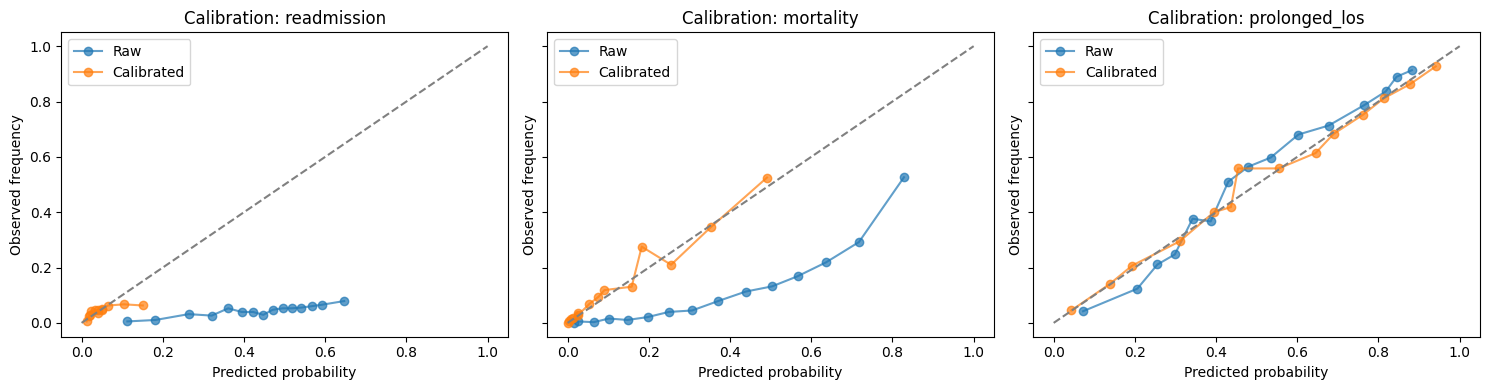

In [43]:
# Calibration (reliability) curves for all targets
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Collect target specs: (name, label_col, model artifact prefix, already have base readmission objects in memory)
calibration_targets = [
    ("readmission", "readmission_label", final_model, iso, y_te, cal_proba_test),
]

# Load added target models & calibrators from disk to ensure reproducibility
for tgt_name, label_col in [("mortality", "mortality_label"), ("prolonged_los", "prolonged_los_label")]:
    import joblib, numpy as np
    model_path = ARTIFACTS_DIR / f"model_{tgt_name}.joblib"
    iso_path = ARTIFACTS_DIR / f"isotonic_{tgt_name}.joblib"
    if not model_path.exists():
        print(f"Warning: missing model artifact for {tgt_name}")
        continue
    model_t = joblib.load(model_path)
    iso_t = joblib.load(iso_path)
    y_all = labels_df[label_col].astype(int).to_numpy()
    subj_to_pos = {sid:i for i,sid in enumerate(subject_index)}
    idx_te_local = np.array([subj_to_pos[s] for s in sid_te])
    y_te_local = y_all[idx_te_local]
    raw_prob = model_t.predict_proba(X_te)[:,1]
    cal_prob = iso_t.transform(raw_prob)
    calibration_targets.append((tgt_name, label_col, model_t, iso_t, y_te_local, cal_prob))

n_cols = 3
fig, axes = plt.subplots(1, len(calibration_targets), figsize=(5*len(calibration_targets),4), sharey=True)
if len(calibration_targets) == 1:
    axes = [axes]

for ax, (tgt_name, label_col, model_obj, iso_obj, y_true_t, cal_prob) in zip(axes, calibration_targets):
    # raw (if available)
    raw_prob = model_obj.predict_proba(X_te)[:,1]
    frac_pos_raw, mean_pred_raw = calibration_curve(y_true_t, raw_prob, n_bins=15, strategy='quantile')
    frac_pos_cal, mean_pred_cal = calibration_curve(y_true_t, cal_prob, n_bins=15, strategy='quantile')
    ax.plot(mean_pred_raw, frac_pos_raw, marker='o', label='Raw', alpha=0.7)
    ax.plot(mean_pred_cal, frac_pos_cal, marker='o', label='Calibrated', alpha=0.7)
    ax.plot([0,1],[0,1], linestyle='--', color='gray')
    ax.set_title(f"Calibration: {tgt_name}")
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('Observed frequency')
    ax.legend()
plt.tight_layout()
plt.show()

          target       auc    pr_auc     brier  threshold  f1_at_threshold  \
0    readmission  0.605000  0.057552  0.041406   0.379097         0.087432   
1      mortality  0.846343  0.390910  0.079399   0.182642         0.433720   
2  prolonged_los  0.816222  0.807373  0.174810   0.379097         0.769321   

   precision_at_threshold  recall_at_threshold  
0                0.065844             0.130081  
1                0.353938             0.559937  
2                0.686007             0.875670  


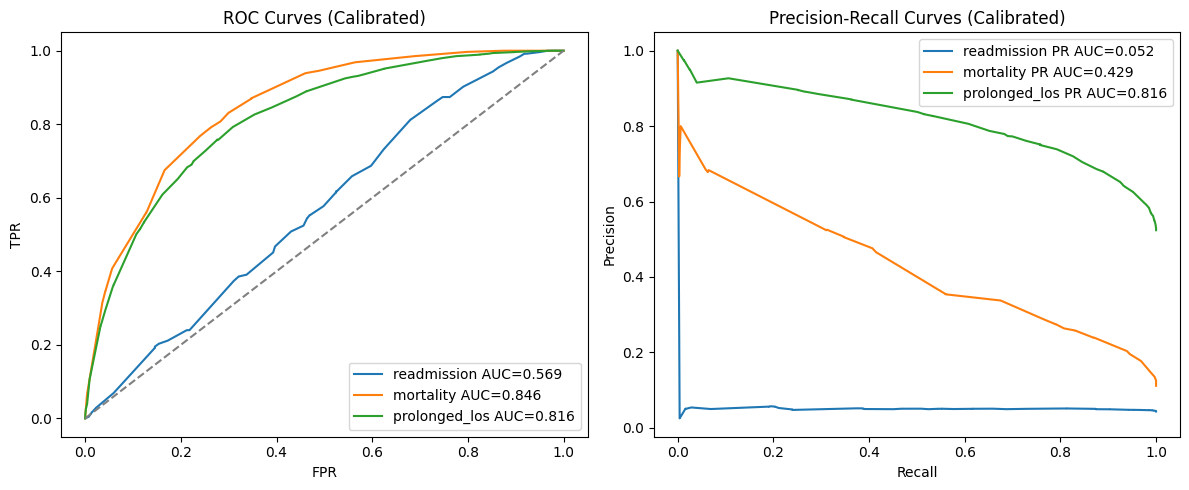

Combined metrics written to metrics_all.json


In [44]:
# Aggregate metrics table, ROC & PR curves, and combined metrics JSON
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc as sk_auc

# Collect metrics from existing variables / files
summary_rows = []
# Readmission already has report, threshold_info, etc. Build row from existing variables
summary_rows.append({
    'target':'readmission',
    'auc': auc,
    'pr_auc': pr,
    'brier': brier,
    'threshold': best_thr,
    'f1_at_threshold': th_metrics['f1'],
    'precision_at_threshold': th_metrics['precision'],
    'recall_at_threshold': th_metrics['recall']
})
# Add multi_metrics entries
for tgt, res in multi_metrics.items():
    summary_rows.append({
        'target': tgt,
        'auc': res['auc'],
        'pr_auc': res['pr_auc'],
        'brier': res['brier'],
        'threshold': res['threshold'],
        'f1_at_threshold': res['f1_at_threshold'],
        'precision_at_threshold': res['precision_at_threshold'],
        'recall_at_threshold': res['recall_at_threshold']
    })
metrics_df = pd.DataFrame(summary_rows)
print(metrics_df)

# ROC & PR curves for each target using calibrated test probabilities
# For readmission we already have proba_test_cal and y_te
roc_data = []
pr_data = []
roc_y = {'readmission': (y_te, proba_test_cal)}
# Load other target test probabilities by recomputing from saved models (calibrated)
from joblib import load as jobload
for tgt in ['mortality','prolonged_los']:
    model = jobload(ARTIFACTS_DIR / f'model_{tgt}.joblib')
    iso_tgt = jobload(ARTIFACTS_DIR / f'isotonic_{tgt}.joblib')
    # reconstruct test indices and labels
    y_all = labels_df[f'{tgt}_label'].astype(int).to_numpy()
    y_te_local = y_all[idx_te]
    raw = model.predict_proba(X_te)[:,1]
    cal = iso_tgt.transform(raw)
    roc_y[tgt] = (y_te_local, cal)

fig, axes = plt.subplots(1,2, figsize=(12,5))
for tgt,(yt,pt) in roc_y.items():
    fpr,tpr,_ = roc_curve(yt, pt)
    roc_auc = sk_auc(fpr,tpr)
    axes[0].plot(fpr,tpr,label=f"{tgt} AUC={roc_auc:.3f}")
    prec,rec,_ = precision_recall_curve(yt, pt)
    pr_auc_val = sk_auc(rec,prec)
    axes[1].plot(rec,prec,label=f"{tgt} PR AUC={pr_auc_val:.3f}")
axes[0].plot([0,1],[0,1],'--',color='grey')
axes[0].set_title('ROC Curves (Calibrated)')
axes[0].set_xlabel('FPR'); axes[0].set_ylabel('TPR')
axes[0].legend()
axes[1].set_title('Precision-Recall Curves (Calibrated)')
axes[1].set_xlabel('Recall'); axes[1].set_ylabel('Precision')
axes[1].legend()
plt.tight_layout()
plt.show()

# Write combined metrics JSON
combined = {row['target']:{k: float(row[k]) if k!='target' else row[k] for k in row.keys()} for row in summary_rows}
with open(ARTIFACTS_DIR / 'metrics_all.json','w') as f:
    json.dump(combined, f, indent=2)
print('Combined metrics written to metrics_all.json')

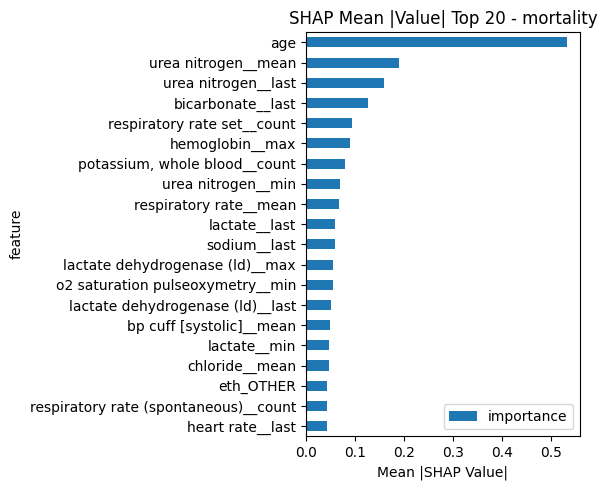

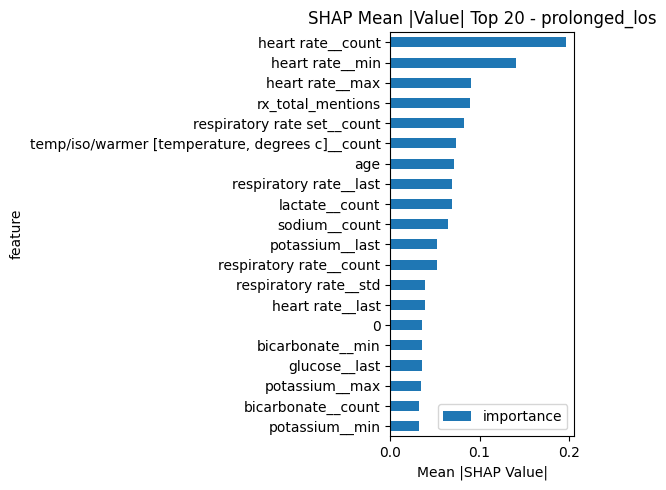

Stored top SHAP features (first 5 each):
mortality [('age', 0.5330799221992493), ('urea nitrogen__mean', 0.18970660865306854), ('urea nitrogen__last', 0.15928813815116882), ('bicarbonate__last', 0.12821826338768005), ('respiratory rate set__count', 0.09400500357151031)]
prolonged_los [('heart rate__count', 0.1964002549648285), ('heart rate__min', 0.1412128508090973), ('heart rate__max', 0.0907590314745903), ('rx_total_mentions', 0.08968508988618851), ('respiratory rate set__count', 0.08227221667766571)]


In [45]:
# SHAP importance (sampled) for mortality & prolonged LOS
import shap, numpy as np, pandas as pd
from joblib import load as jobload
shap.initjs()
SAMPLE_SHAP = 400  # adjust if needed
shap_results = {}

for tgt in ['mortality','prolonged_los']:
    model = jobload(ARTIFACTS_DIR / f'model_{tgt}.joblib')
    # Sample from training set indices for stability
    rng = np.random.default_rng(SEED+7)
    sample_idx = rng.choice(len(X_tr), size=min(SAMPLE_SHAP, len(X_tr)), replace=False)
    explainer_t = shap.TreeExplainer(model)
    shap_vals = explainer_t.shap_values(X_tr[sample_idx])
    shap_abs_mean = np.abs(shap_vals).mean(axis=0)
    order = np.argsort(shap_abs_mean)[::-1][:20]
    top_feat = [(feat_cols[i], float(shap_abs_mean[i])) for i in order]
    shap_results[tgt] = top_feat
    df_plot = pd.DataFrame({'feature':[feat_cols[i] for i in order], 'importance':[shap_abs_mean[i] for i in order]})
    ax = df_plot.iloc[::-1].plot(kind='barh', x='feature', y='importance', figsize=(6,5), title=f'SHAP Mean |Value| Top 20 - {tgt}')
    ax.set_xlabel('Mean |SHAP Value|')
    plt.tight_layout()
    plt.show()

print('Stored top SHAP features (first 5 each):')
for k,v in shap_results.items():
    print(k, v[:5])